# Module 2: Data Analysis
## Sprint 2: Inferential Statistical Analysis
## Part 5: Inferential Statistical Analysis of the Podcast Reviews


The data used for analysis is from [Podcast Reviews Dataset](https://www.kaggle.com/thoughtvector/podcastreviews).



# Table of Contents

* [Data Import and Cleaning](#chapter1)
* [The Exploratory Data Analysis ](#chapter2)
* [NLP](#chapter3)
* [Normality Assumption](#chapter4)
* [One-way ANOVA)](#chapter5)
    * [Dataframe for statistical analysis](#section5.1)
    * [Q-Q Plots](#section5.2) 
    * [Hypothesis Testing](#section5.3)
* [The Sentiment Classifier](#chapter6)
* [Conclusions](#chapter7)




## Data Import and Cleaning  <a class="anchor" id="chapter1"></a>

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pandas.core.common import SettingWithCopyWarning
import collections
import regex as re
import random
import string
import nltk
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [2]:
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
colors = ['#00876c','#449c6e', '#70af6f', '#9bc271', '#c8d377', '#f7e382','#f6c468','#f3a457','#ed834e','#e3614d','#d43d51', 
          '#003f5c', '#2f4b7c', '#665191', '#a05195', '#d45087', '#f95d6a']
sns.set_palette(sns.color_palette(colors))
sns.set_style('white')
sns.set_context('notebook')

In [4]:
# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect("database.sqlite")

df_without_duplicates = pd.read_sql_query('''SELECT A.podcast_id, A.category, B.title, C.content, C.author_id, C.rating, C.created_at
                             FROM categories A
                             JOIN podcasts B
                             ON A.podcast_id = B.podcast_id
                             JOIN reviews C
                             ON C.podcast_id = A.podcast_id
                             ORDER BY 
                             rating DESC;''', con) #default - inner join, in this case I chose 
                                                   #this join type due to the shorter duration of loading the dataset

# Verify that result of SQL query is stored in the dataframe
print(df_without_duplicates.head(1))

con.close()

                         podcast_id category                       title  \
0  c61aa81c9b929a66f0c1db6cbe5d8548     arts  Backstage at Tilles Center   

                                             content        author_id  rating  \
0  Thanks for providing these insights.  Really e...  F7E5A318989779D       5   

                  created_at  
0  2018-04-24T12:05:16-07:00  


In [5]:
df_without_duplicates.head(2)

,podcast_id,category,title,content,author_id,rating,created_at
0,c61aa81c9b929a66f0c1db6cbe5d8548,arts,Backstage at Tilles Center,Thanks for providing these insights. Really e...,F7E5A318989779D,5,2018-04-24T12:05:16-07:00
1,c61aa81c9b929a66f0c1db6cbe5d8548,arts-performing-arts,Backstage at Tilles Center,Thanks for providing these insights. Really e...,F7E5A318989779D,5,2018-04-24T12:05:16-07:00


In [6]:
#Check missing values
df_without_duplicates.isnull().sum()

podcast_id    0
category      0
title         0
content       0
author_id     0
rating        0
created_at    0
dtype: int64

In [7]:
df_without_duplicates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1531789 entries, 0 to 1531788
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   podcast_id  1531789 non-null  object
 1   category    1531789 non-null  object
 2   title       1531789 non-null  object
 3   content     1531789 non-null  object
 4   author_id   1531789 non-null  object
 5   rating      1531789 non-null  int64 
 6   created_at  1531789 non-null  object
dtypes: int64(1), object(6)
memory usage: 81.8+ MB


Here I am going to change ```created_at``` data type from <i>object</i> to <i>datetime</i> to create additional columns (year, month) for following graphs:

In [8]:
df_without_duplicates['created_at'] = pd.to_datetime(df_without_duplicates['created_at'])

The EDA analysis led me to change some categories names because it do not show or gives additional valuable information:

In [9]:
df_without_duplicates['category'].unique()

array(['arts', 'arts-performing-arts', 'music', 'arts-design',
       'education', 'society-culture', 'arts-visual-arts', 'technology',
       'arts-food', 'society-culture-personal-journals', 'comedy',
       'arts-fashion-beauty', 'tv-film', 'society-culture-places-travel',
       'kids-family', 'religion-spirituality', 'business',
       'society-culture-philosophy', 'spirituality', 'business-careers',
       'christianity', 'hinduism', 'business-investing', 'judaism',
       'islam', 'buddhism'], dtype=object)

In [12]:
df_without_duplicates['category'].replace(to_replace = ['arts-performing-arts', 'arts-design',
                                            'arts-visual-arts', 'arts-food', 'arts-fashion-beauty'], value = 'arts', inplace = True)
df_without_duplicates['category'].replace(to_replace = ['society-culture-personal-journals', 'society-culture-places-travel',
                                            'society-culture-philosophy'], value = 'society-culture', inplace = True)
df_without_duplicates['category'].replace(to_replace = ['spirituality', 'christianity',
                                            'hinduism', 'judaism', 'islam', 'buddhism'], value = 'religion-spirituality', inplace = True)
df_without_duplicates['category'].replace(to_replace = ['business-investing'], value = 'business', inplace = True)

In [13]:
df_without_duplicates.category.unique()

array(['arts', 'music', 'education', 'society-culture', 'technology',
       'comedy', 'tv-film', 'kids-family', 'religion-spirituality',
       'business', 'business-careers'], dtype=object)

Here I can see that is going to be problematic to use statistical tools for hypothesis testing. All categories have pretty high ratings and lower ratings are considered outliers. In the <b>Normality Assumption</b> section this is going to be explained further.

In [14]:
df_without_duplicates.groupby('category').describe()

rating                                             
                          count      mean       std  min  25%  50%  75%  max
category                                                                    
arts                   151513.0  4.738702  0.855718  1.0  5.0  5.0  5.0  5.0
business               160856.0  4.800816  0.778939  1.0  5.0  5.0  5.0  5.0
business-careers        38882.0  4.886837  0.568501  1.0  5.0  5.0  5.0  5.0
comedy                 251908.0  4.638650  1.043981  1.0  5.0  5.0  5.0  5.0
education              117439.0  4.796899  0.778560  1.0  5.0  5.0  5.0  5.0
kids-family             64771.0  4.750428  0.837745  1.0  5.0  5.0  5.0  5.0
music                   42089.0  4.784932  0.773252  1.0  5.0  5.0  5.0  5.0
religion-spirituality  178415.0  4.812471  0.764734  1.0  5.0  5.0  5.0  5.0
society-culture        368714.0  4.596096  1.078186  1.0  5.0  5.0  5.0  5.0
technology              35127.0  4.546076  1.117673  1.0  5.0  5.0  5.0  5.0
tv-film                122075.0  4.521589  1.166546  1.0  5.0  5.0  5.0  5.0

## The Exploratory Data Analysis <a class="anchor" id="chapter2"></a>

This section covers the overall analysis of dataset.

In [15]:
df_category_ =  df_without_duplicates.groupby(['category', 'created_at'],as_index=False).rating.mean()

In [16]:
df_category_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1282348 entries, 0 to 1282347
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype                                 
---  ------      --------------    -----                                 
 0   category    1282348 non-null  object                                
 1   created_at  1282348 non-null  datetime64[ns, pytz.FixedOffset(-420)]
 2   rating      1282348 non-null  float64                               
dtypes: datetime64[ns, pytz.FixedOffset(-420)](1), float64(1), object(1)
memory usage: 39.1+ MB


I did not like the format of column ```created_at```, thus I did year/month/day seperation and got only year column. This helped me to visualize data more efficiently.

In [17]:
df_category_['year'] = df_category_['created_at'].dt.year

In [18]:
df_category_ = df_category_.drop(columns=['created_at'])

In [19]:
df_category_.head(2)

,category,rating,year
0,arts,5.0,2005
1,arts,5.0,2005


In [20]:
category_mean_year =  df_category_.groupby(['category','year'],as_index=False).rating.mean()

In [21]:
category_mean_year.head(2)

,category,year,rating
0,arts,2005,4.863636
1,arts,2006,4.612342


<Figure size 720x1080 with 0 Axes>

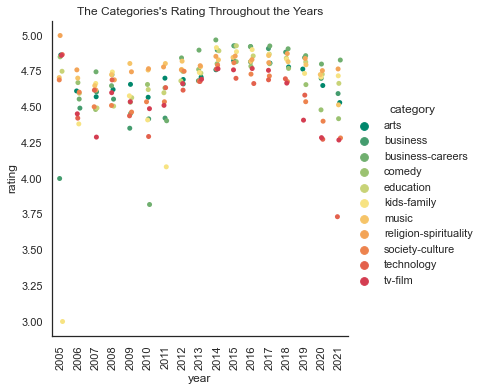

In [22]:
plt.figure(figsize=(10, 15))
sns.catplot(x="year", y="rating", hue="category", data=category_mean_year)
plt.xticks(rotation = 90)
plt.title('The Categories\'s Rating Throughout the Years');

Here we can see that all categories shares approximately the same mean.

However, the tip categories that are seen the graph are the green marked (arts, business, business-careers, comedy, education). 

Interestingly, the podcasts rating are growing since 2010 till 2014.

The lowest mean of 3.0 is for kids-family category in 2005. 

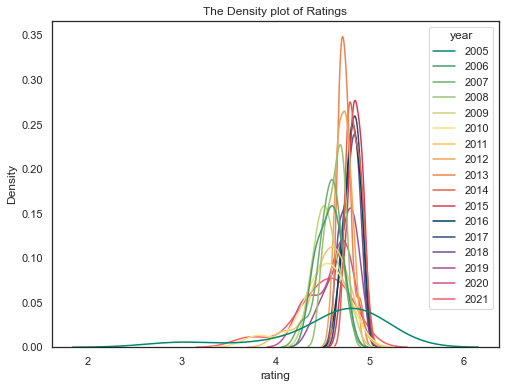

In [23]:
plt.figure(figsize=(8, 6))
sns.kdeplot(
   data=category_mean_year, x='rating', hue='year', palette=colors)
plt.title('The Density plot of Ratings');

The highest rating count probability is in 2013 and the lowest - 2005. 

The peak of podcasts rating could be increased due to podcast definition [qualification](https://www.statista.com/chart/10713/podcast-listeners-in-the-united-states/). Also, it is reported that [<i>One in three Americans aged 12 and older now listen to all forms of online radio</i>](https://www.edisonresearch.com/the-infinite-dial-2013-navigating-digital-platforms/) in 2013.


The following steps are going to include podcasts that have been rated since 2005:

In [24]:
podcast_mean_year =  df_without_duplicates.groupby(['title','created_at'],as_index=False).rating.mean()

In [25]:
podcast_mean_year['month'] = podcast_mean_year['created_at'].dt.month
podcast_mean_year['year'] = podcast_mean_year['created_at'].dt.year

In [26]:
podmy = podcast_mean_year.groupby(['title','year'],as_index=False).rating.mean()
podmy.head()

,title,year,rating
0,"""Artists Behind the Action""",2019,5.000000
1,#Hip-Hop #Reggae #Electronic Dance Music,2017,5.000000
2,#Hip-Hop #Reggae #Electronic Dance Music,2018,4.500000
3,#Hip-Hop #Reggae #Electronic Dance Music,2019,3.666667
4,#Hip-Hop #Reggae #Electronic Dance Music,2020,5.000000


In [27]:
podmy = podmy[podmy['title'].map(podmy['title'].value_counts()) > 16]

In [28]:
podmy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136 entries, 2274 to 91392
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   title   136 non-null    object 
 1   year    136 non-null    int64  
 2   rating  136 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 4.2+ KB


In [29]:
podmy['title'].value_counts()

Audio Dharma                                          17
Mac Geek Gab (Enhanced AAC)                           17
This Week in Science – The Kickass Science Podcast    17
Mosaic - Erwin McManus                                17
NBC Meet the Press                                    17
All Songs Considered                                  17
Distorted View Daily                                  17
NosillaCast Apple Podcast                             17
Name: title, dtype: int64

<Figure size 720x432 with 0 Axes>

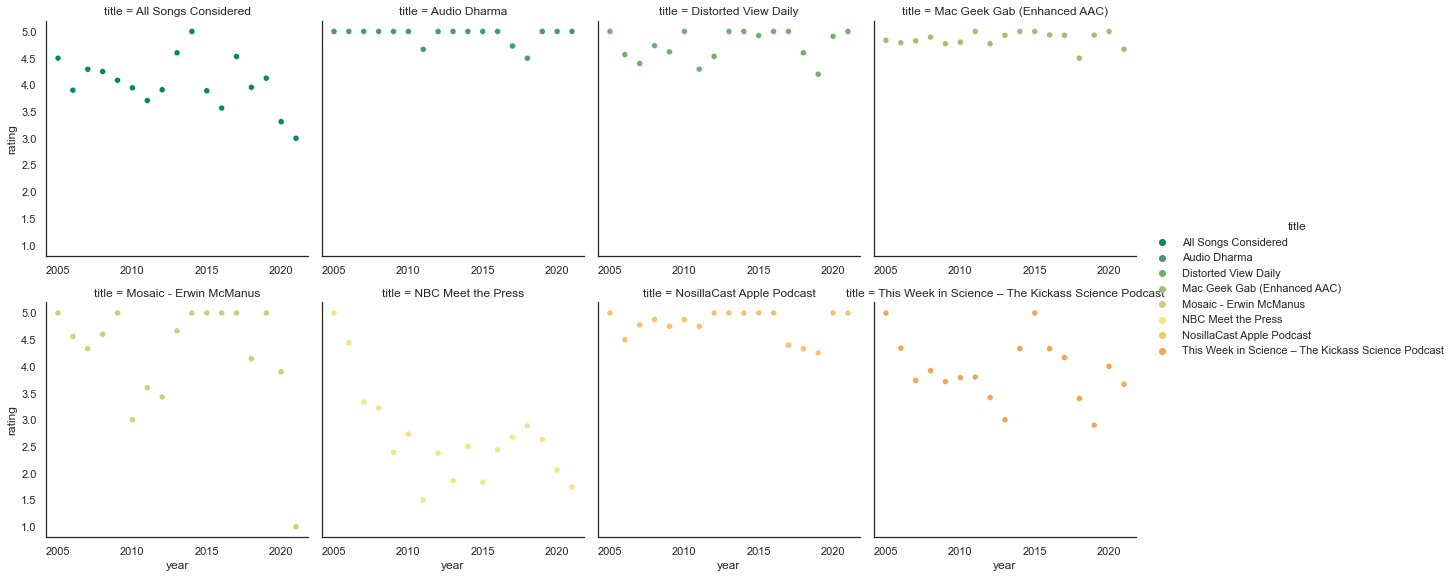

In [30]:
fig = plt.figure(figsize=(10, 6))
sns.relplot(
    data=podmy,
    x='year', y='rating',
    hue='title', col = 'title', col_wrap=4,
    height=4,  facet_kws=dict(sharex=False));

- From the graph above it is seen that NBC Meet the Press rating is falling throughout the 17 years. It can be failing due to its themes and the podcast host [(mostly political)](https://chartable.com/podcasts/nbc-meet-the-press/reviews)
- The most consistent rating is for Audio Dharma and Mac Greek Gab.
- Interestingly, science podcast This Week in Science rating dropped in 2016 and the rating got higher only in 2020.

## NLP <a class="anchor" id="chapter3"></a>

In [31]:
df_without_duplicates.head(1)

,podcast_id,category,title,content,author_id,rating,created_at
0,c61aa81c9b929a66f0c1db6cbe5d8548,arts,Backstage at Tilles Center,Thanks for providing these insights. Really e...,F7E5A318989779D,5,2018-04-24 12:05:16-07:00


In [32]:
content_rating =  df_without_duplicates.groupby(['category','content', 'created_at'],as_index=False).rating.mean()

In [33]:
content_rating.head(1)

,category,content,created_at,rating
0,arts,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!,2016-05-20 06:09:37-07:00,5.0


This particular code and sample_df is going to be used for Normality Assumption and NLP.

Here I randomly sampled 500 podcasts from the dataset using ```random.sample```.

In [34]:
# random sample for 500 podcasts 
unique_podcast_id = list(df_without_duplicates['podcast_id'].unique())
random.seed(30) # set a seed so that everytime we will extract same sample
sample_podcast_id = random.sample(unique_podcast_id, 500)
sample_df = df_without_duplicates[df_without_duplicates['podcast_id'].isin(sample_podcast_id)].reset_index(drop=True)

In [35]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [36]:
STOP_WORDS = stopwords.words()

# removing the emojies
EMOJI_PATTERN = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)


def cleaning(text):
    """
    Convert to lowercase.
    Rremove URL links, special characters and punctuation.
    Tokenize and remove stop words.
    """
    text = text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('[’“”…]', '', text)

    text = EMOJI_PATTERN.sub(r'', text)

    # removing the stop-words
    text_tokens = word_tokenize(text)
    tokens_without_sw = [
        word for word in text_tokens if not word in STOP_WORDS]
    filtered_sentence = (" ").join(tokens_without_sw)
    text = filtered_sentence

    return text

In [37]:
if __name__ == "__main__":
    max_rows = 500  # 'None' to read whole file
    df = sample_df

    dt = df['content'].apply(cleaning)

    word_count = Counter(" ".join(dt).split()).most_common(10)
    word_frequency = pd.DataFrame(word_count, columns = ['Word', 'Frequency'])
    #print(word_frequency)

<Figure size 576x432 with 0 Axes>

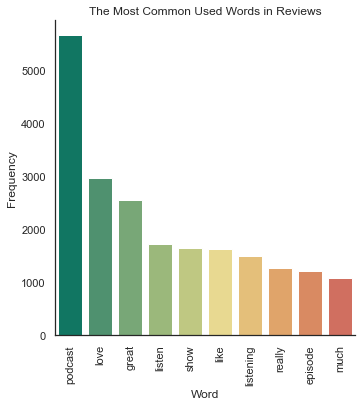

In [38]:
plt.figure(figsize=(8, 6));
sns.catplot(x='Word', y='Frequency', data = word_frequency, kind='bar')
plt.title('The Most Common Used Words in Reviews')
plt.xticks(rotation = 90);

Since this dataset has mostly positive values (the rating of 5), most of the common words are related to ratings. In the graphs, that can be seen: majority of common words has positive meaning (love, great, really, like).

## Normality Assumption <a class="anchor" id="chapter4"></a>



In the beggining of EDA, I showed the outlier graph (boxplot if I can call it like that), showed that all ratings below 5 are considered as outliers. The Normality Assumption is done just to prove that this dataset data is non-normality distributed if we are considering only ratings between categories.

sample_df is going to be grouped to interested columns for the following analysis.

In [39]:
sample_df = sample_df[['category', 'rating', 'content', 'author_id', 'created_at']]

I was hoping to do ANOVA Test and test if all categories rating mean is equal to each other (H0 hypothesis). However, the histplot shows that not categories count is not distributed noramlly. In conclusion, it would be wrongly to assume or compare those categories rating and draw a hypothesis.

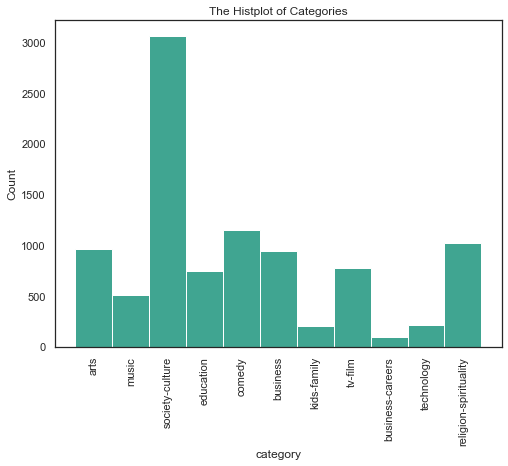

In [40]:
plt.figure(figsize=(8, 6))
sns.histplot(data=sample_df, x="category", binwidth=3)
plt.xticks(rotation = 90)
plt.title('The Histplot of Categories');

Here we can see that data is non-normaly distributed.

In [41]:
sample_df.describe()

,rating
count,9662.000000
mean,4.699234
std,0.957106
min,1.000000
25%,5.000000
50%,5.000000
75%,5.000000
max,5.000000


Also, the table illustrates what I meant by existing outliers and how data is distributes. Quartiles and median have equal values.

## One-Way ANOVA<a class="anchor" id="chapter5"></a>

### Dataframe for statistical analysis <a class="anchor" id="section5.1"></a>

However, I thought that I can compare each year rating counts of selected categories.

In [42]:
sample_df['year'] = sample_df['created_at'].dt.year

In [43]:
sample_df['category'].unique()

array(['arts', 'music', 'society-culture', 'education', 'comedy',
       'business', 'kids-family', 'tv-film', 'business-careers',
       'technology', 'religion-spirituality'], dtype=object)

In [44]:
df_for_tests = pd.DataFrame(sample_df.groupby(['category', 'year', 'rating']).size().reset_index(name='counts'))
df_for_tests.head()

,category,year,rating,counts
0,arts,2006,5,12
1,arts,2007,5,12
2,arts,2008,1,2
3,arts,2008,5,8
4,arts,2009,1,4


In [45]:
df_for_tests.columns

Index(['category', 'year', 'rating', 'counts'], dtype='object')

In [46]:
options = ['comedy', 'education', 'business', 'arts']

In [47]:
rslt_df = df_for_tests[(df_for_tests['rating'] == 5) & df_for_tests['category'].isin(options)]
rslt_df.head()

,category,year,rating,counts
0,arts,2006,5,12
1,arts,2007,5,12
3,arts,2008,5,8
6,arts,2009,5,9
8,arts,2010,5,11


In [48]:
year_options = [2006, 2007, 2008, 2009]

Not all categories are mentioned in all years, I selected to do analysis from 2010.

In [49]:
rslt_df = rslt_df.loc[~rslt_df['year'].isin(year_options)]
rslt_df.head()

,category,year,rating,counts
8,arts,2010,5,11
12,arts,2011,5,14
14,arts,2012,5,12
16,arts,2013,5,11
18,arts,2014,5,33


In [50]:
test_df = rslt_df[['category', 'counts']]

### Q-Q Plots <a class="anchor" id="section5.2"></a>

Here I am doing the normality assumption check by plotting a normal probability plot (Q-Q plots).

If the data falls into a largely straight-line pattern, then it can be assumed that data is distributed normally.

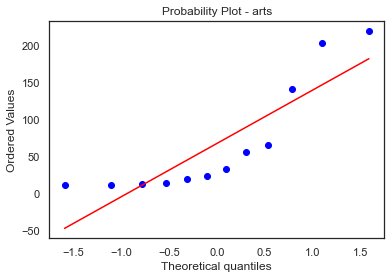

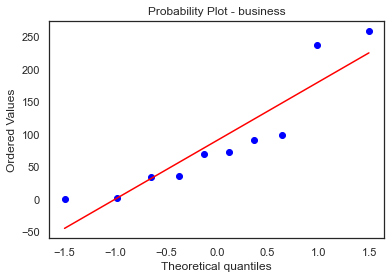

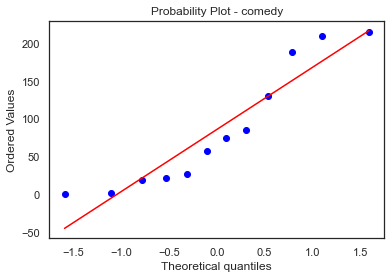

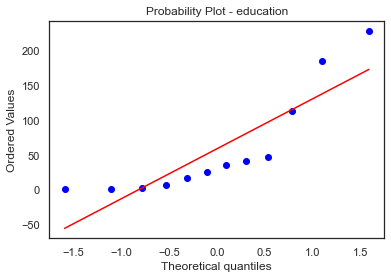

In [51]:
unique_cat = test_df['category'].unique()
for cat in unique_cat:
    stats.probplot(test_df[test_df['category'] == cat]['counts'], dist="norm", plot=plt)
    plt.title("Probability Plot - " +  cat)
    plt.show()

Here I am going to assume that for each category the rating count is normally distributed.

The following steps are going to be related to ANOVA hypothesis testing. I am going to create ANOVA table backbone and calculate all needed statistical variables for it.

Below code cells are for understanding how the table is distributed and what variables are in each table cell:

In [52]:
# Create ANOVA backbone table
data_ex = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table_ex = pd.DataFrame(data_ex, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table_ex.set_index('Source of Variation', inplace = True)

In [53]:
anova_table_ex['SS']['Between Groups'] = 'SSTR'
anova_table_ex['SS']['Within Groups'] = 'SSE'
anova_table_ex['SS']['Total'] = 'SSTO'
anova_table_ex['df']['Between Groups'] = 'c-1'
anova_table_ex['df']['Within Groups'] = 'n-c'
anova_table_ex['df']['Total'] = 'n-1'
anova_table_ex['MS']['Between Groups'] = 'MSTR'
anova_table_ex['MS']['Within Groups'] = 'MSE'
anova_table_ex['F']['Between Groups'] = '(MSTR/MSE)'
anova_table_ex['P-value']['Between Groups'] = 'p'
anova_table_ex['F crit']['Between Groups'] = 'Fα; c-1, n-c'
anova_table_ex

,SS,df,MS,F,P-value,F crit
Source of Variation,,,,,,
Between Groups,SSTR,c-1,MSTR,(MSTR/MSE),p,"Fα; c-1, n-c"
Within Groups,SSE,n-c,MSE,,,
Total,SSTO,n-1,,,,


Terminology:
- SSTR - treatment sum of squares
- SSE - sum of squares
- SSTO - sum of the squares of the deviations af all the observations
- c - number of independent groups
- n - number of total observations in the analysis
- MSRT - mean square (treatment)
- MSE - mean square (error)
- F - An F-statistic is the ratio of two variances, or technically, two mean squares.
- SS - sum of squares. The total amount of variability comes from two possible sources, namely:
                    1. Difference among the groups, called treatment (TR)
                    2. Difference within the groups, called error (E)
- df - degrees of freedom
- MS - mean squares

### Hypothesis Testing <a class="anchor" id="section5.3"></a>

H₀: μ<sub>1</sub>= μ<sub>2</sub> = μ<sub>3</sub> = μ<sub>4</sub>, all rating counts' means are equal to each other.

H₁: Not all rating counts' means are equal

α = 0.05

According to F test statistics:

In [54]:
# Create ANOVA backbone table
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Source of Variation', inplace = True)

# calculate SSTR and update anova table
x_bar = test_df['counts'].mean()
SSTR = test_df.groupby('category').count() * (test_df.groupby('category').mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR['counts'].sum()

# calculate SSE and update anova table
SSE = (test_df.groupby('category').count() - 1) * test_df.groupby('category').std()**2
anova_table['SS']['Within Groups'] = SSE['counts'].sum()

# calculate SSTR and update anova table
SSTR = SSTR['counts'].sum() + SSE['counts'].sum()
anova_table['SS']['Total'] = SSTR

# update degree of freedom
anova_table['df']['Between Groups'] = test_df['category'].nunique() - 1
anova_table['df']['Within Groups'] = test_df.shape[0] - test_df['category'].nunique()
anova_table['df']['Total'] = test_df.shape[0] - 1

# calculate MS
anova_table['MS'] = anova_table['SS'] / anova_table['df']

# calculate F 
F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
anova_table['F']['Between Groups'] = F

# p-value
anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# F critical 
alpha = 0.05
# possible types "right-tailed, left-tailed, two-tailed"
tail_hypothesis_type = "two-tailed"
if tail_hypothesis_type == "two-tailed":
    alpha /= 2
anova_table['F crit']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# Final ANOVA Table
anova_table

,SS,df,MS,F,P-value,F crit
Source of Variation,,,,,,
Between Groups,7539.733333,3,2513.244444,0.386112,0.763554,3.445689
Within Groups,273382.266667,42,6509.101587,,,
Total,280922.0,45,6242.711111,,,


In [55]:
# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
conclusion = "Failed to reject the null hypothesis."
if anova_table['P-value']['Between Groups'] <= alpha:
    conclusion = "Null Hypothesis is rejected."
print("F-score is:", anova_table['F']['Between Groups'], " and p value is:", anova_table['P-value']['Between Groups'])    
print(conclusion)
    
# The critical value approach
print("\n--------------------------------------------------------------------------------------")
print("Approach 2: The critical value approach to hypothesis testing in the decision rule")
conclusion = "Failed to reject the null hypothesis."
if anova_table['F']['Between Groups'] > anova_table['F crit']['Between Groups']:
    conclusion = "Null Hypothesis is rejected."
print("F-score is:", anova_table['F']['Between Groups'], " and critical value is:", anova_table['F crit']['Between Groups'])
print(conclusion)

Approach 1: The p-value approach to hypothesis testing in the decision rule
F-score is: 0.38611233988842003  and p value is: 0.7635537337741973
Failed to reject the null hypothesis.

--------------------------------------------------------------------------------------
Approach 2: The critical value approach to hypothesis testing in the decision rule
F-score is: 0.38611233988842003  and critical value is: 3.445688910242221
Failed to reject the null hypothesis.


## The Sentiment Classifier <a class="anchor" id="chapter6"></a>

For the Sentiment Classifier, I am going to sort the ratings into good and bad (5, 4 are good,the other ones- no :(( )

In [56]:
podcasts = df_without_duplicates[['podcast_id','title', 'rating', 'content']]
podcasts.head()

,podcast_id,title,rating,content
0,c61aa81c9b929a66f0c1db6cbe5d8548,Backstage at Tilles Center,5,Thanks for providing these insights. Really e...
1,c61aa81c9b929a66f0c1db6cbe5d8548,Backstage at Tilles Center,5,Thanks for providing these insights. Really e...
2,c61aa81c9b929a66f0c1db6cbe5d8548,Backstage at Tilles Center,5,Thanks for providing these insights. Really e...
3,c61aa81c9b929a66f0c1db6cbe5d8548,Backstage at Tilles Center,5,Super excited to see this podcast grow. So man...
4,c61aa81c9b929a66f0c1db6cbe5d8548,Backstage at Tilles Center,5,Super excited to see this podcast grow. So man...


Here I am going to provide that the dataframe does not contain any unnecessary emojis or other unwanted characters.

In [57]:
podcasts.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))
podcasts.head(2)

,podcast_id,title,rating,content
0,c61aa81c9b929a66f0c1db6cbe5d8548,Backstage at Tilles Center,5,Thanks for providing these insights. Really e...
1,c61aa81c9b929a66f0c1db6cbe5d8548,Backstage at Tilles Center,5,Thanks for providing these insights. Really e...


5 and 4 are encoded 1, and 1-2 are encoded 0.


In [58]:
def sentiment(n):
    return 1 if n >= 4 else 0
podcasts['sentiment'] = podcasts['rating'].apply(sentiment)
podcasts.head(2)

,podcast_id,title,rating,content,sentiment
0,c61aa81c9b929a66f0c1db6cbe5d8548,Backstage at Tilles Center,5,Thanks for providing these insights. Really e...,1
1,c61aa81c9b929a66f0c1db6cbe5d8548,Backstage at Tilles Center,5,Thanks for providing these insights. Really e...,1


The below code is just for combining two columns into one:

In [59]:
podcasts['all_features'] = podcasts[['title', 'content']].agg(' '.join, axis=1)

In [60]:
X = podcasts['all_features']
y = podcasts['sentiment']

In [61]:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [62]:
cv = CountVectorizer()
ctmTr = cv.fit_transform(X_train)
X_test_dtm = cv.transform(X_test)

In [63]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(ctmTr, y_train)

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [64]:
y_pred_class = model.predict(X_test_dtm)
y_pred_class

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [65]:
accuracy_score(y_test, y_pred_class)

0.960535111816748

In [66]:
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.83      0.67      0.74     32436
           1       0.97      0.99      0.98    350512

    accuracy                           0.96    382948
   macro avg       0.90      0.83      0.86    382948
weighted avg       0.96      0.96      0.96    382948



Here we can see that the Sentiment analizer model has 96% accuracy score. Thus, F1 sccore shows that predictions were made correctly (For bad ratings - 0.74, for good ratings - 0.98).

## Conclusions <a class="anchor" id="chapter7"></a>

* The Podcasts are rated highly: below 5 ratings are considered outliers.
* The most ratings were get in 2013, least - 2005.
* Since the podcasts are mostly rated 5, the content includes words that have positive meaning.
* Dataset Ratings are non-normaly distributed
* Throughout the years comedy, education, business and arts ratings counts are approximately the same. That means, that these categories are not only best rated, but have similar popularity among the raters.
* The Sentiment Classifier showed good prediction - accuracy score is 96%, and those predictions were made correctly.

What else could be done?

* The relationship between rank score and most common word (correlation map)
* The insights into dataset and worldwide situation (e.g. How COVID-19 had impact on podcast popularity?)

---

## Resources/References

- https://www.datacamp.com/community/tutorials/recommender-systems-python
- https://realpython.com/build-recommendation-engine-collaborative-filtering/
- https://towardsdatascience.com/recommendation-system-in-python-lightfm-61c85010ce17
- https://www.kaggle.com/gspmoreira/recommender-systems-in-python-101
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.median_test.html
- https://towardsdatascience.com/6-ways-to-test-for-a-normal-distribution-which-one-to-use-9dcf47d8fa93
- https://www.isixsigma.com/tools-templates/normality/dealing-non-normal-data-strategies-and-tools/
- https://people.richland.edu/james/lecture/m170/tbl-chi.html
- https://learnui.design/tools/data-color-picker.html#palette
- https://www.podcastinsights.com/podcast-statistics/
- https://www.itl.nist.gov/div898/handbook/prc/section4/prc423.htm

Uniform distribution:
- https://www.investopedia.com/terms/u/uniform-distribution.asp




Egle Vitkunaite, 2021-11-05


galima prasiplesti ka dariau ir kodel neitraukiau (palaikyti balansa)
galima parasyti ka dariau, kas isejo, kas ne

- https://towardsdatascience.com/anova-test-with-python-cfbf4013328b
- https://towardsdatascience.com/a-complete-sentiment-analysis-algorithm-in-python-with-amazon-product-review-data-step-by-step-2680d2e2c23b
- https://towardsdatascience.com/anova-test-with-python-cfbf4013328b
- https://www.graphpad.com/support/faq/the-anova-table-ss-and-df-in-two-way-anova/